# ELE510 Image Processing with robot vision: LAB, Exercise 6, Image features detection.

**Purpose:** *To learn about the edges and corners features detection, and their descriptors.*

The theory for this exercise can be found in chapter 7 of the text book [1] and in appendix C in the compendium [2]. See also the following documentations for help:
- [OpenCV](https://opencv.org/opencv-python-free-course/)
- [numpy](https://numpy.org/doc/stable/)
- [matplotlib](https://matplotlib.org/stable/contents.html)
- [scipy](https://docs.scipy.org/doc/)


**IMPORTANT:** Read the text carefully before starting the work. In
many cases it is necessary to do some preparations before you start the work
on the computer. Read necessary theory and answer the theoretical part
first. The theoretical and experimental part should be solved individually.
The notebook must be approved by the lecturer or his assistant.

**Approval:**
<div class="alert alert-block alert-success">
The current notebook should be submitted on CANVAS as a single pdf file. 
</div>

<div class="alert alert-block alert-info">
    To export the notebook in a pdf format, goes to File -> Download as -> PDF via LaTeX (.pdf).
</div>

**Note regarding the notebook**: The theoretical questions can be answered directly on the notebook using a *Markdown* cell and LaTex commands (if relevant). In alternative, you can attach a scan (or an image) of the answer directly in the cell.

Possible ways to insert an image in the markdown cell:

`![image name]("image_path")`

`<img src="image_path" alt="Alt text" title="Title text" />`


**Under you will find parts of the solution that is already programmed.**

<div class="alert alert-block alert-info">
    <p>You have to fill out code everywhere it is indicated with `...`</p>
    <p>The code section under `######## a)` is answering subproblem a) etc.</p>
</div>

## Problem 1

**Intensity edges** are pixels in the image where the intensity (or graylevel) function changes rapidly.

The **Canny edge detector** is a classic algorithm for detecting intensity edges in a grayscale image that relies on the gradient magnitude. The algorithm was developed by John F. Canny in 1986. It is a multi-stage algorithm that provides good and reliable detection.

**a)** Create the **Canny algorithm**, described at pag. 336 (alg. 7.1). For the last step (`EDGELINKING`) you can either use the algorithm 7.3 at page 338 or the `HYSTERESIS THRESHOLD` algorithm 10.3 described at page 451.
All the following images are taken from the text book [1].

![canny.png](images/canny.png)

![nonmaxsuppression.png](images/nonmaxsuppression.png)

![edgelinking.png](images/edgelinking.png)

**Remember:**

- Sigma (second parameter in the Canny algorithm) is not necessary for the calculation since the Sobel operator (in opencv) combines the Gaussian smoothing and differentiation, so the results is nore or less resistant to the noise. 
- We are defining the low and high thresholds manually in order to have a better comparison with the predefined opencv function. It is possible to extract the low and high thresholds automatically from the image but it is not required in this problem.

**b)** Test your algorithm with a image of your choice and compare your results with the predefined function in opencv: 

```python
cv2.Canny(img, t_low, t_high, L2gradient=True)
``` 
[Documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny).

### P.S. : 
<div class="alert alert-block alert-info">
The goal of this problem it is not to create a **perfect** replication of the algorithm in opencv, but to understand the various steps involved and to be able to extract the edges from an ima ge using these steps.
</div>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Sobel operator to find the first derivate in the horizontal and vertical directions
def computeImageGradient(Im):
    # Sobel operator  to find the first derivate in the horizontal and vertical directions
        
    ## TODO: The default ksize is 3, try different values and comment the result 
    g_x = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    g_y = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
        
    # Calculate the magnitude and the gradient direction like it is performed during the assignment 4 (problem 2a)
    G_mag = np.hypot(g_x,g_y)
    G_phase = np.arctan2(g_y, g_x)
            
    return G_mag, G_phase

In [3]:
# NonMaxSuppression algorithm
def nonMaxSuppression(G_mag, G_phase):
    G_localmax = np.zeros((G_mag.shape))
    # For each pixel, adjust the phase to ensure that -pi/8 <= theta < 7*pi/8
    # Here x represents the columns and y represent the rows!

    for y in range(1, G_mag.shape[0]-1):
        for x in range(1, G_mag.shape[1]-1):
            theta = G_phase[y, x]
            neigh_1, neigh_2 = 0, 0

            if theta >= 7*np.pi/8 or theta < -7*np.pi/8:
                neigh_1 = G_mag[y, x-1]
                neigh_2 = G_mag[y, x+1]
            elif -7*np.pi/8 <= theta < -5*np.pi/8:
                neigh_1 = G_mag[y-1, x-1]
                neigh_2 = G_mag[y+1, x+1]
            elif -5*np.pi/8 <= theta < -3*np.pi/8:
                neigh_1 = G_mag[y-1, x]
                neigh_2 = G_mag[y+1, x]
            elif -3*np.pi/8 <= theta < -np.pi/8:
                neigh_1 = G_mag[y-1, x+1]
                neigh_2 = G_mag[y+1, x-1]

            if -np.pi/8 <= theta < np.pi/8:
                neigh_1 = G_mag[y, x-1]
                neigh_2 = G_mag[y, x+1]
            elif np.pi/8 <= theta < 3*np.pi/8:
                neigh_1 = G_mag[y-1, x-1]
                neigh_2 = G_mag[y+1, x+1]
            elif 3*np.pi/8 <= theta < 5*np.pi/8:
                neigh_1 = G_mag[y-1, x]
                neigh_2 = G_mag[y+1, x]
            elif 5*np.pi/8 <= theta < 7*np.pi/8:
                neigh_1 = G_mag[y-1, x+1]
                neigh_2 = G_mag[y+1, x-1]

            # If the pixel is a local maximum in the direction of the gradient, then retain the value, otherwise set it to 0
            if G_mag[y, x] >= neigh_1 and G_mag[y, x] >= neigh_2:
                G_localmax[y, x] = G_mag[y, x]

    return G_localmax

In [4]:
def edgeLinking(G_localmax, t_low, t_high):
    I_edges = np.zeros_like(G_localmax)

    # Set the threshold image and perform edge linking (or hysteresis thresholding)

    frontier = []
    # Find high threshold pixels and initialize the frontier
    for x in range(1, G_localmax.shape[0] - 1):
        for y in range(1, G_localmax.shape[1] - 1):
            if G_localmax[x, y] > t_high:
                frontier.append((x, y))
                I_edges[x, y] = 1

    # Perform edge linking using a while loop
    while frontier:
        p = frontier.pop()
        p_x, p_y = p[0], p[1]
        neighbors = [(p_x+1, p_y-1), (p_x+1, p_y), (p_x+1, p_y+1),
                     (p_x, p_y-1), (p_x, p_y+1), (p_x-1, p_y-1),
                     (p_x-1, p_y), (p_x-1, p_y+1)]

        for (i, j) in neighbors:
            if t_low < G_localmax[i, j] <= t_high and I_edges[i, j] != 1:
                frontier.append((i, j))
                I_edges[i, j] = 1

    return I_edges

In [5]:
"""
Function that performs the Canny algorithm.

The entire cell is locked, thus you can only test the function and NOT change it!

Input: 
    - Im: image in grayscale
    - t_low: first threshold for the hysteresis procedure (edge linking)
    - t_high: second threshold for the hysteresis procedure (edge linking)
"""
def my_cannyAlgorithm(Im, t_low, t_high):
    ## Compute the image gradient 
    G_mag, G_phase = computeImageGradient(Im)
    
    ## NonMaxSuppression algorithm 
    G_localmax = nonMaxSuppression(G_mag, G_phase)
        
    ## Edge linking
    if t_low>t_high: t_low, t_high = t_high, t_low
    I_edges = edgeLinking(G_localmax, t_low, t_high)
    
    plt.figure(figsize=(30,30))
    plt.subplot(141), plt.imshow(G_mag, cmap='gray')
    plt.title('Magnitude image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(G_phase, cmap='gray')
    plt.title('Phase image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(G_localmax, cmap='gray')
    plt.title('After non maximum suppression.'), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(I_edges, cmap='gray')
    plt.title('Threshold image.'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return I_edges

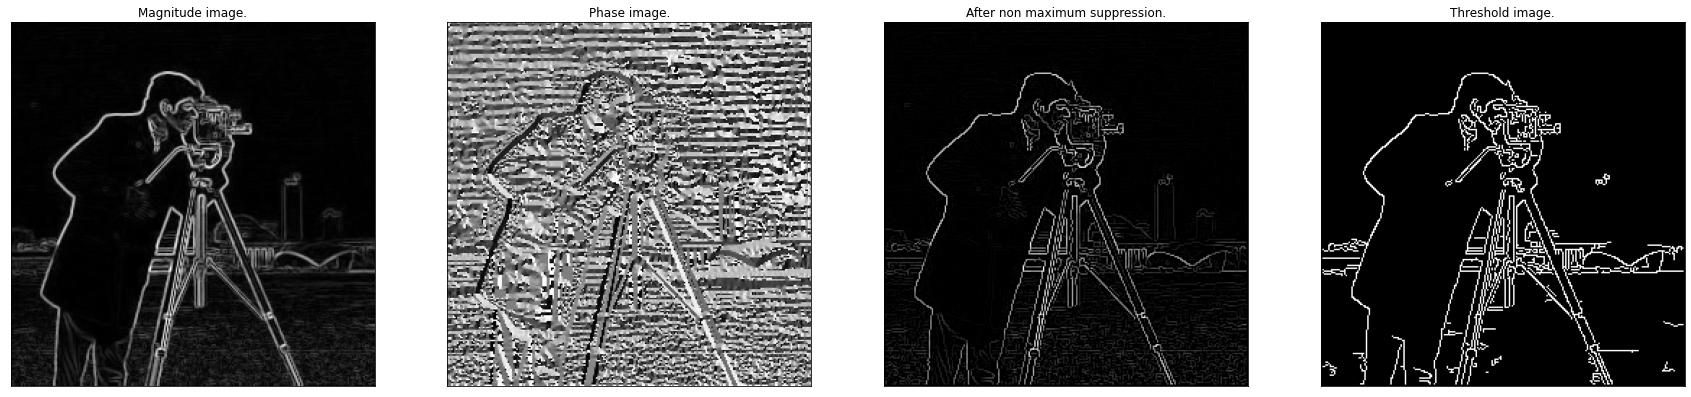

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

Im = cv2.imread(os.path.join(os.getcwd(),'images/cameraman.jpg'), cv2.IMREAD_GRAYSCALE)

t_low = 100
t_high = 250
I_edges = my_cannyAlgorithm(Im, t_low, t_high)

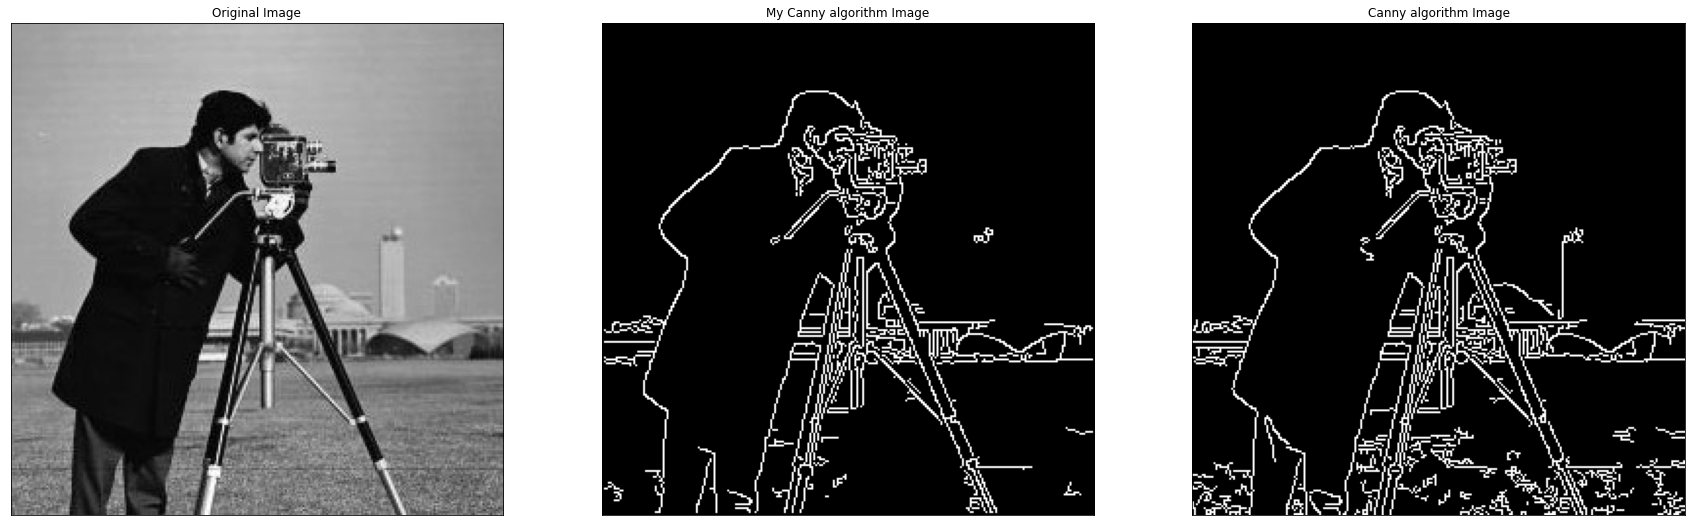

In [7]:
# LOCKED cell: useful to check and visualize the results.

plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(Im, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(I_edges, cmap='gray')
plt.title('My Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(cv2.Canny(Im,t_low, t_high, L2gradient=False), cmap='gray')
plt.title('Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Problem 2

One of the most popular approaches to feature detection is the **Harris corner detector**, after a work of Chris Harris and Mike Stephens from 1988.

**a)** Use the function in opencv `cv2.cornerHarris(...)` ([Documentation](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)) with `blockSize=3, ksize=3, k=0.04` with the **./images/chessboard.png** image to detect the corners (you can find the image on CANVAS).

**b)** Plot the image with the detected corners found.

**Hint**: Use the function `cv2.drawMarker(...)` ([Documentation](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#ga644c4a170d4799a56b29f864ce984b7e)) to show the corners in the image.

In [8]:
def getCornersFromHarris(Im, blockSize, ksize, k, markerSize, thickness):
    # Convert the image to grayscale if it's not already
    gray_img = cv2.cvtColor(Im, cv2.COLOR_BGR2GRAY) if len(Im.shape) > 2 else Im

    # Compute the Harris corner response
    dst = cv2.cornerHarris(gray_img, blockSize=blockSize, ksize=ksize, k=k)

    # Normalize the response image
    dst_norm = cv2.normalize(dst, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Dilate the response to make corners more prominent
    dst = cv2.dilate(dst, None)

    # Define a threshold for identifying corners
    threshold = 0.05 * dst.max()

    # Create an output image for drawing corners
    corners = np.zeros(gray_img.shape, dtype=np.uint8)

    # Draw markers at corner locations
    for x in range(dst_norm.shape[0]):
        for y in range(dst_norm.shape[1]):
            if dst[x, y] > threshold:
                cv2.drawMarker(Im, (y, x), color=(255, 0, 0), markerType=cv2.MARKER_TILTED_CROSS, markerSize=markerSize, thickness=thickness)
                cv2.drawMarker(corners, (y, x), color=255, markerType=cv2.MARKER_TILTED_CROSS, markerSize=markerSize, thickness=thickness)

    return dst_norm, corners

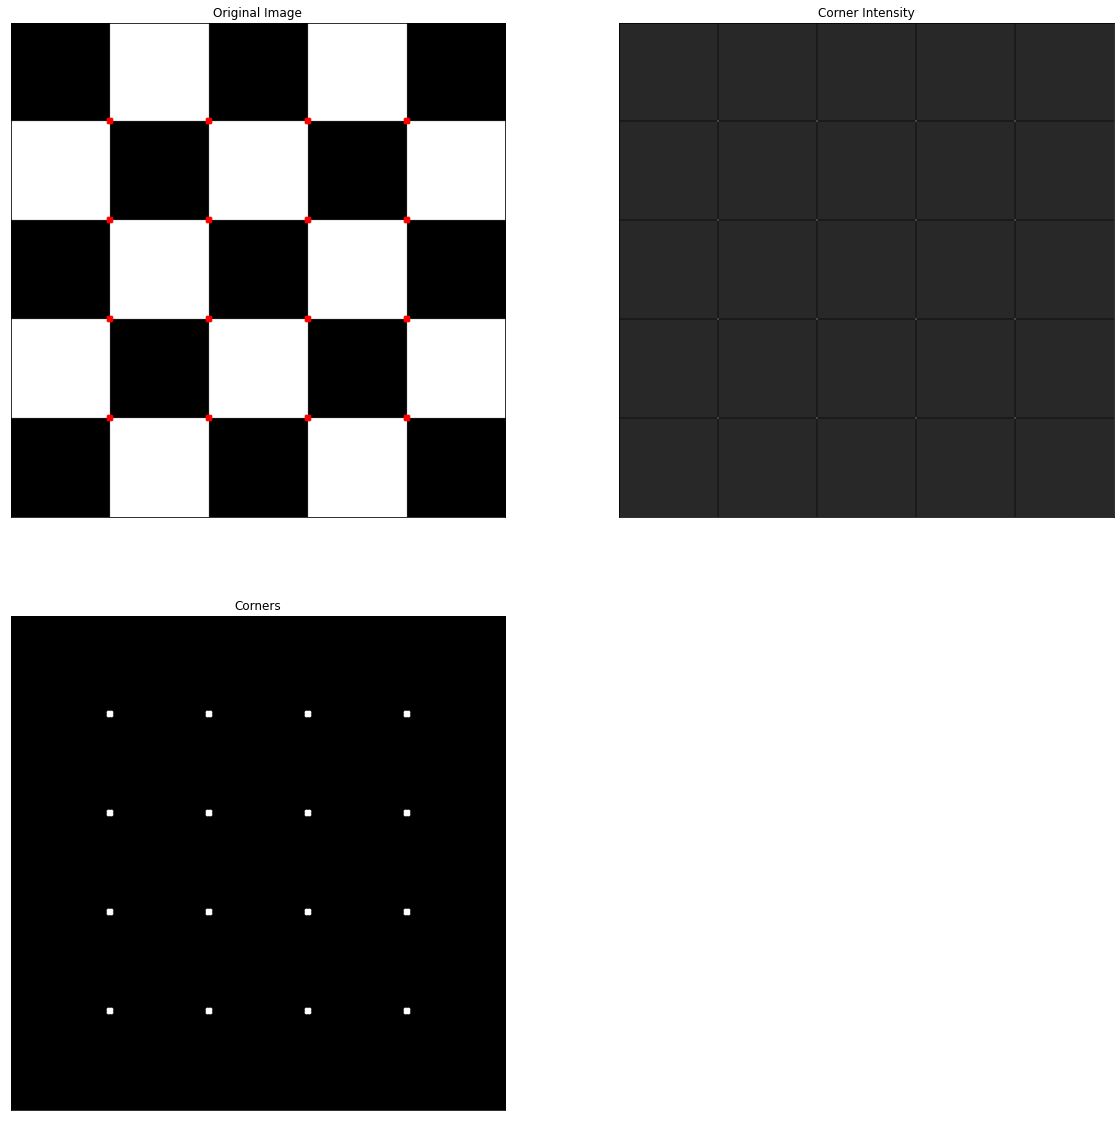

In [9]:
# Load the image
Im = cv2.imread(os.path.join(os.getcwd(),'images/chessboard.png'))

# Get corners using Harris corner detection
dst_norm, corners = getCornersFromHarris(Im, blockSize=3, ksize=3, k=0.04, markerSize=10, thickness=10)

# Display the original image, corner intensity, and corners
plt.figure(figsize=(20, 20))
plt.subplot(221), plt.imshow(Im)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(dst_norm, cmap="gray", vmin=0, vmax=255)
plt.title('Corner Intensity'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(corners, cmap="gray", vmin=0, vmax=255)
plt.title('Corners'), plt.xticks([]), plt.yticks([])
plt.show()

**c)** Detect the corners using the images **./images/arrow_1.jpg**, **./images/arrow_2.jpg** and **./images/arrow_3.jpg**; describe and compare the results in the three images.

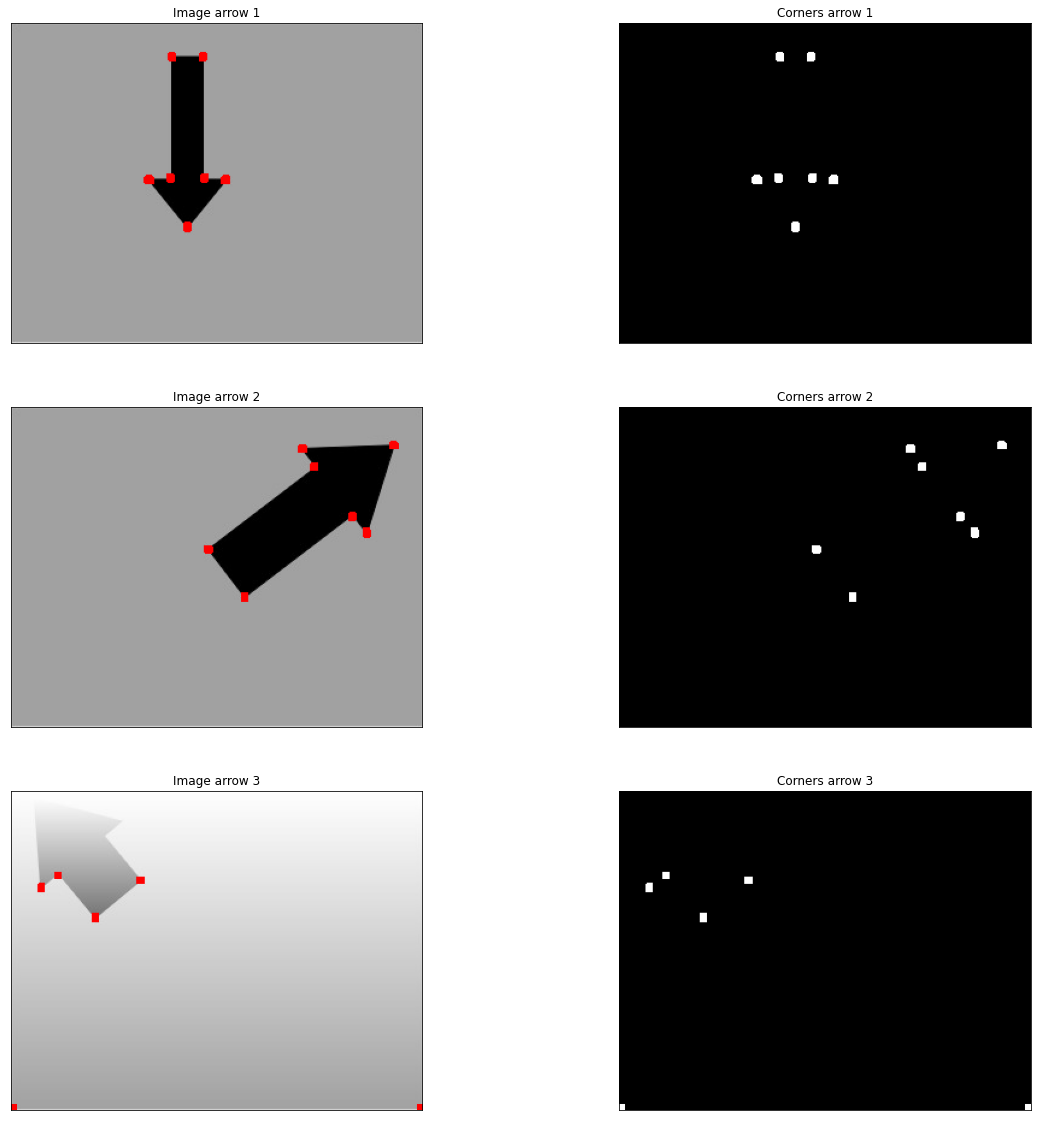

In [10]:
#Load Images
Im_1 = cv2.imread(os.path.join(os.getcwd(),'images/arrow_1.jpg'))
Im_2 = cv2.imread(os.path.join(os.getcwd(),'images/arrow_2.jpg'))
Im_3 = cv2.imread(os.path.join(os.getcwd(),'images/arrow_3.jpg'))

# Get corners for each image
dst_norm_1, corners_1 = getCornersFromHarris(Im_1, blockSize=3, ksize=3, k=0.04, markerSize=2, thickness=1)
dst_norm_2, corners_2 = getCornersFromHarris(Im_2, blockSize=3, ksize=3, k=0.04, markerSize=2, thickness=1)
dst_norm_3, corners_3 = getCornersFromHarris(Im_3, blockSize=3, ksize=3, k=0.04, markerSize=2, thickness=1)

# Plot images and corners
plt.figure(figsize=(20,20))
plt.subplot(321), plt.imshow(Im_1,cmap="gray")
plt.title('Image arrow 1'), plt.xticks([]), plt.yticks([])
plt.subplot(322), plt.imshow(corners_1,cmap="gray")
plt.title('Corners arrow 1'), plt.xticks([]), plt.yticks([])
plt.subplot(323), plt.imshow(Im_2,cmap="gray")
plt.title('Image arrow 2'), plt.xticks([]), plt.yticks([])
plt.subplot(324), plt.imshow(corners_2,cmap="gray")
plt.title('Corners arrow 2'), plt.xticks([]), plt.yticks([])
plt.subplot(325), plt.imshow(Im_3,cmap="gray")
plt.title('Image arrow 3'), plt.xticks([]), plt.yticks([])
plt.subplot(326), plt.imshow(corners_3,cmap="gray")
plt.title('Corners arrow 3'), plt.xticks([]), plt.yticks([])
plt.show()

**d)** What happen if you change (increase/decrease) the `k` constant for the "corner points"? 

The k constant in Harris corner detection (often denoted as the "kappa" parameter) is a critical parameter that affects the sensitivity of the corner detection algorithm. Changing the k value can have a significant impact on the number and quality of detected corner points.

* Increasing k makes the corner response function more sensitive to corners, so it will detect more points that exhibit corner-like characteristics. On the contrary, reducing k makes the algorithm less sensitive to corners, so it will detect fewer points with corner-like characteristics.
* With a high k value, the algorithm may also detect noise or non-corner features as corners, leading to false positives. But ff k is too small, some true corners may not be detected, leading to false negatives.

# Problem 3 

**a)** What is the SIFT approach? Describe the steps involved.

SIFT (Scale-Invariant Feature Transform) is a popular computer vision algorithm used for feature extraction and object recognition. It is known for its robustness to variations in scale, orientation, illumination, and viewpoint. It's widely used in tasks such as image matching, object recognition, and image stitching. 

01. Scale-Space Extrema Detection:
* The first step involves finding potential keypoints (interest points) in the image across multiple scales.
* To achieve scale invariance, the image is repeatedly blurred at different levels using Gaussian filters to create an image pyramid.
* At each scale level, the Difference of Gaussians (DoG) is computed by subtracting adjacent blurred images. The DoG represents the scale-normalized Laplacian of the image.
* Keypoints are detected by finding local maxima and minima in the DoG pyramid. These points correspond to potential keypoints at different scales.

02. Keypoint Localization:
* After detecting potential keypoints, the algorithm performs a precise localization step to improve the accuracy of keypoint positions.
* It fits a 3D quadratic function to the DoG values in the scale-space to determine the keypoint's subpixel location and scale.
* Keypoints with low contrast or those located near edges are discarded as they are less stable and reliable.

03. Orientation Assignment:
* SIFT assigns an orientation to each keypoint to make the descriptors rotation invariant.
* A local gradient orientation histogram is created in the region around each keypoint. The dominant orientation in the histogram is chosen as the keypoint's orientation.
* Keypoint descriptors will be computed relative to this orientation.

04. Descriptor Calculation:
* For each keypoint, a descriptor is generated to represent its local appearance.
* A region around the keypoint is divided into subregions, and gradient histograms are computed for each subregion.
* These histograms are combined to form a single high-dimensional vector, known as the SIFT descriptor.
* The descriptor is normalized and can handle changes in illumination and contrast.

05. Keypoint Matching:
* Once descriptors are computed for keypoints in two images, a matching step is performed to find corresponding keypoints between the images.
* Common distance metrics like Euclidean distance or normalized cross-correlation are used to measure the similarity between descriptors.
* Keypoints with the closest matches are considered as correspondences.

06. Outlier Rejection:
* In practice, not all keypoint matches are accurate due to occlusions, noise, or other factors.
* Techniques like RANSAC (Random Sample Consensus) are often used to reject outlier matches and estimate geometric transformations between images.

07. Object Recognition and Localization:
* SIFT keypoints and their descriptors can be used for various computer vision tasks, including object recognition, image stitching, and 3D reconstruction.
* By matching keypoints between reference and query images, you can determine the position, orientation, and scale of objects in the scene.

**b)** Why this approach is more popular than the Harris detector?

* SIFT constructs a scale-space pyramid and detects features at multiple scales, making it robust to objects appearing at different sizes in the image. The Harris corner detector does not inherently provide scale invariance.
* SIFT descriptors are rotation invariant, which means they can match features even when the object has undergone rotational transformations. The Harris corner detector doesn't have built-in rotation invariance.
* SIFT generates highly distinctive and robust descriptors for keypoints. These descriptors are well-suited for accurate feature matching and object recognition. Harris corners lack descriptors, so they are primarily used for corner detection and may not provide enough information for matching and recognition tasks.
* SIFT is known for its robustness to changes in illumination and contrast. The Harris corner detector may be sensitive to changes in lighting conditions.
* SIFT provides a framework for feature matching and object recognition, allowing you to find corresponding keypoints between images and estimate transformations, making it versatile for applications like image stitching, object tracking, and 3D reconstruction.

**c)** Explain the difference between a feature detector and a feature descriptor.

* A feature detector's primary purpose is to identify distinctive points or regions in an image that are likely to correspond to important structures, patterns, or objects. These points are often referred to as keypoints or interest points. 

    Whereas, a feature descriptor's main purpose is to characterize the local neighborhood around a keypoint or feature point. It encodes information about the intensity or gradient distribution in the region to create a unique and distinctive representation.
* The output of a feature detector consists of the coordinates (location) of detected keypoints in the image and, in some cases, additional information like the keypoint's scale and orientation. 

    The output of a feature descriptor is a numerical vector that represents the local image content around a keypoint. This vector is used for matching and recognition tasks.
* Common feature detectors include the Harris corner detector, FAST (Features from Accelerated Segment Test), and DoG (Difference of Gaussians) detector used in SIFT.

    Common feature descriptors include SIFT (Scale-Invariant Feature Transform) descriptors, SURF (Speeded-Up Robust Features) descriptors, and BRIEF (Binary Robust Independent Elementary Features) descriptors.


### Delivery (dead line) on CANVAS: 13.10.2023 at 23:59


## Contact
### Course teacher
Professor Kjersti Engan, room E-431,
E-mail: kjersti.engan@uis.no

### Teaching assistant
Saul Fuster Navarro, room E-401
E-mail: saul.fusternavarro@uis.no


Jorge Garcia Torres Fernandez, room E-401
E-mail: jorge.garcia-torres@uis.no


## References

[1] S. Birchfeld, Image Processing and Analysis. Cengage Learning, 2016.

[2] I. Austvoll, "Machine/robot vision part I," University of Stavanger, 2018. Compendium, CANVAS.